In [436]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import datetime
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sample_data
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math


mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [437]:
df = pd.read_csv('/content/inflation interest unemployment.csv')

In [438]:
df_usa = df[df['country'] == 'United States']

In [439]:
df_usa.head()

,country,year,"Inflation, consumer prices (annual %)","Inflation, GDP deflator (annual %)",Real interest rate (%),Deposit interest rate (%),Lending interest rate (%),"Unemployment, total (% of total labor force) (national estimate)","Unemployment, total (% of total labor force) (modeled ILO estimate)",iso3c,iso2c,adminregion,incomeLevel
13156,United States,1970,5.838255,5.602170,2.185400,NaN,7.910000,4.9,NaN,USA,US,NaN,High income
13157,United States,1971,4.292767,5.069167,0.622605,NaN,5.723333,5.9,NaN,USA,US,NaN,High income
13158,United States,1972,3.272278,4.322751,0.887229,NaN,5.248333,5.6,NaN,USA,US,NaN,High income
13159,United States,1973,6.177760,5.479881,2.409735,NaN,8.021667,4.9,NaN,USA,US,NaN,High income
13160,United States,1974,11.054805,8.998695,1.651064,NaN,10.798333,5.6,NaN,USA,US,NaN,High income


In [440]:
df_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 13156 to 13207
Data columns (total 13 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   country                                                              52 non-null     object 
 1   year                                                                 52 non-null     int64  
 2   Inflation, consumer prices (annual %)                                52 non-null     float64
 3   Inflation, GDP deflator (annual %)                                   51 non-null     float64
 4   Real interest rate (%)                                               51 non-null     float64
 5   Deposit interest rate (%)                                            0 non-null      float64
 6   Lending interest rate (%)                                            52 non-null     float64
 7   Une

In [441]:
df_usa = df_usa.reset_index(drop = True)

In [442]:
#Delete columns that are not needed
columns_to_delete = ['Deposit interest rate (%)','iso3c', 'iso2c', 'country', 'Inflation, GDP deflator (annual %)', 'adminregion', 'incomeLevel', 'Lending interest rate (%)', 'Unemployment, total (% of total labor force) (national estimate)', 'Unemployment, total (% of total labor force) (modeled ILO estimate)']
df_usa.drop(columns=columns_to_delete, inplace=True)

In [443]:
df_usa.head()

,year,"Inflation, consumer prices (annual %)",Real interest rate (%)
0,1970,5.838255,2.185400
1,1971,4.292767,0.622605
2,1972,3.272278,0.887229
3,1973,6.177760,2.409735
4,1974,11.054805,1.651064


In [444]:
df_usa = df_usa.drop(index = 51, axis = 0)

In [445]:
#Rename to simply Inflation
df_usa = df_usa.rename(columns={"Inflation, consumer prices (annual %)": "Inflation"})

In [446]:
for i in range(len(df_usa.columns)):
  result = adfuller(df_usa[df_usa.columns[i]])

  if result[1] > 0.05:
    print('{} - Series is not stationary'.format(df_usa.columns[i]))
  else:
    print('{} - Series is stationary'.format(df_usa.columns[i]))

year - Series is not stationary
Inflation - Series is not stationary
Real interest rate (%) - Series is not stationary


In [447]:
# Assuming df is your DataFrame with columns 'Year', 'InterestRate', and 'Inflation'
df_usa['Inflation_diff'] = df_usa['Inflation'].diff()

In [448]:
# Assuming df is your DataFrame with columns 'Year', 'InterestRate', and 'Inflation_diff'
seasonal_lag = 12  # Assuming a monthly seasonality, adjust as needed
df_usa['Inflation_seasonal_diff'] = df_usa['Inflation_diff'].diff(seasonal_lag)

In [449]:
# Assuming df is your DataFrame with columns 'Year', 'InterestRate', and 'Inflation_seasonal_diff'
window_size = 5
df_usa['Inflation_detrended'] = df_usa['Inflation_seasonal_diff'] - df_usa['Inflation_seasonal_diff'].rolling(window=window_size).mean()

In [450]:
df_usa = df_usa.dropna()  # Drop rows with missing values

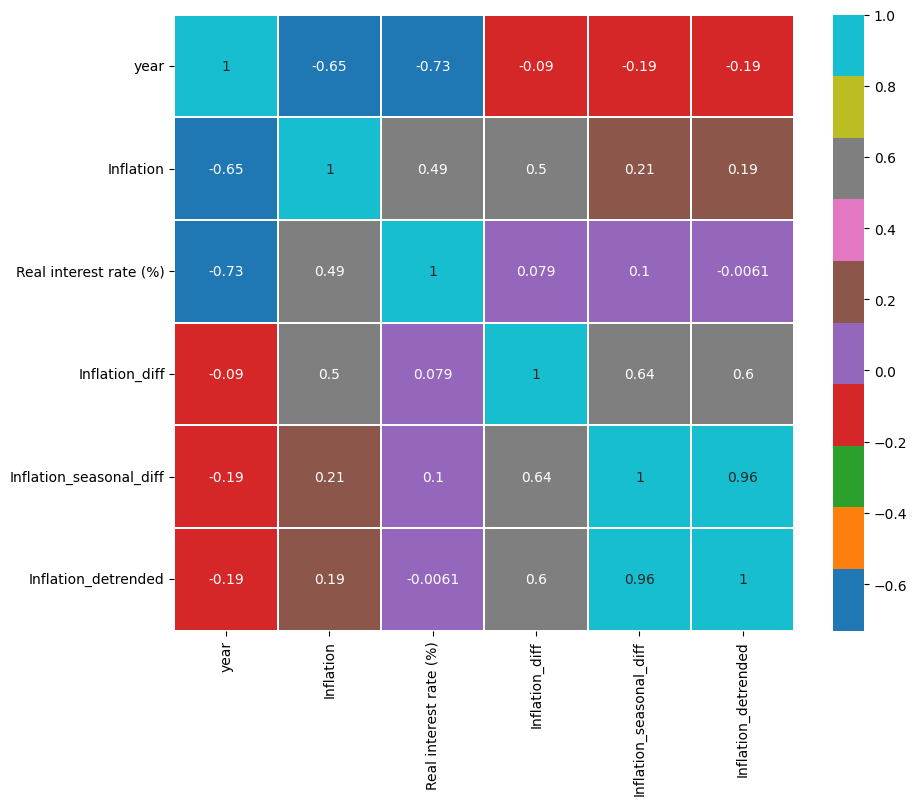

In [451]:
c=df_usa.corr()
sns.heatmap(c, cmap='tab10', linewidths='0.05', annot=True)
plt.show()

In [452]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation_detrended'
X = df_usa[['Real interest rate (%)', 'year']]
y = df_usa['Inflation']

# Ensure that 'Inflation' is correctly named in your DataFrame
# If there is still an issue, print the columns to verify the names
# print(df_usa.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.0021083655774083


In [453]:
adf_test_result = adfuller(df_usa['Inflation'])

print('ADF Statistic:', adf_test_result[0])
print('p-value:', adf_test_result[1])
print('Critical Values:', adf_test_result[4])

# Check if the series is stationary based on the p-value
if adf_test_result[1] <= 0.05:
    print('The series is likely stationary.')
else:
    print('The series is likely non-stationary.')

ADF Statistic: -2.932548790547654
p-value: 0.04169183208759931
Critical Values: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
The series is likely stationary.


In [454]:
df_usa.head()

,year,Inflation,Real interest rate (%),Inflation_diff,Inflation_seasonal_diff,Inflation_detrended
17,1987,3.664563,5.592238,1.766515,3.678173,4.832524
18,1988,4.077741,5.590382,0.413178,3.811512,3.928860
19,1989,4.827003,6.690687,0.749262,-0.007609,0.532978
20,1990,5.397956,6.039749,0.570953,-0.558326,-0.638148
21,1991,4.234964,4.915346,-1.162992,-4.786500,-5.213950


<Axes: xlabel='Real interest rate (%)', ylabel='Inflation'>

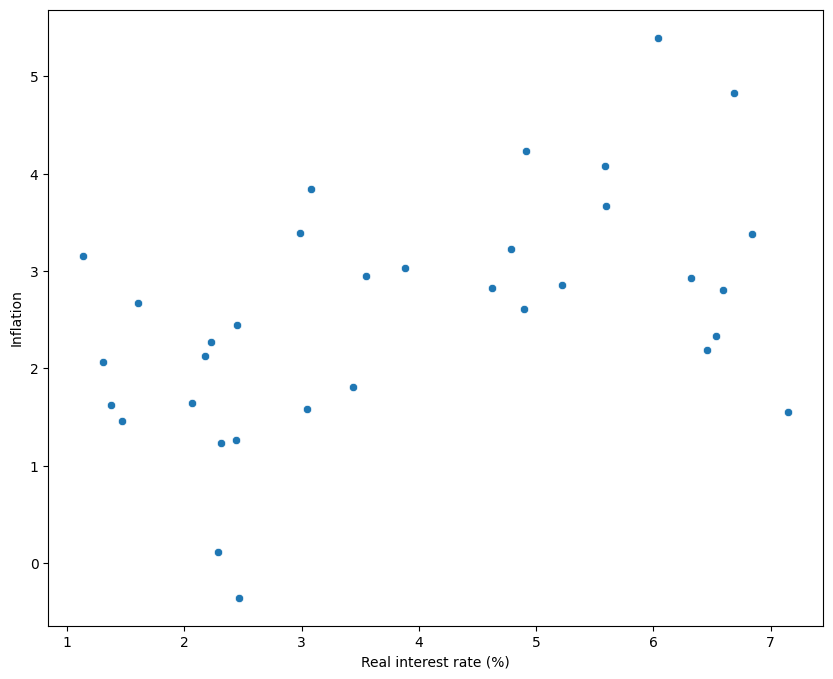

In [455]:
# visualizes the relationship between two variables
sns.scatterplot(data=df_usa, x="Real interest rate (%)", y="Inflation")

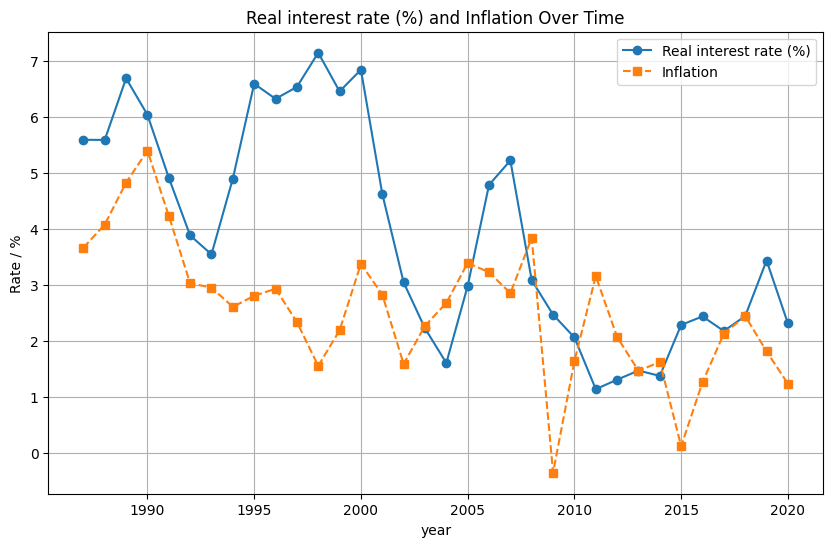

In [456]:
year = df_usa['year']
interest_rate = df_usa['Real interest rate (%)']
inflation = df_usa['Inflation']

# Create a line plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(year, interest_rate, label='Real interest rate (%)', marker='o', linestyle='-')
plt.plot(year, inflation, label='Inflation', marker='s', linestyle='--')

# Add labels and a title
plt.xlabel('year')
plt.ylabel('Rate / %')
plt.title('Real interest rate (%) and Inflation Over Time')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)  # Add grid lines
plt.show()

In [457]:
#from statsmodels.tsa.api import VAR
#from sklearn.metrics import mean_squared_error

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation'
# Split data into training and testing sets
#train_size = int(len(df_usa) * 0.8)
#train, test = df_usa.iloc[:train_size], df_usa.iloc[train_size:]

# Fit the VAR model on the training set
#model = VAR(train[['Real interest rate (%)', 'year', 'Inflation']])
#results = model.fit(maxlags=10)  # Adjust as needed

# Make predictions on the testing set
#forecast = results.forecast(train[['Real interest rate (%)', 'year', 'Inflation']].values, steps=len(test))
#forecast_df = pd.DataFrame(forecast, columns=['Real interest rate (%)', 'year', 'Inflation'])

# Evaluate the model using Mean Squared Error (MSE)
#mse = mean_squared_error(test['Inflation'], forecast_df['Inflation'])
#print(f'Mean Squared Error: {mse}')

# Plotting actual vs forecasted values
#plt.plot(test['year'], test['Inflation'], label='Actual Inflation', marker='o')
#plt.plot(test['year'], forecast_df['Inflation'], label='Forecasted Inflation', marker='o')
##plt.title('Actual vs Forecasted Inflation Values')
#plt.xlabel('Year')
#plt.ylabel('Inflation')
##plt.legend()
#plt.grid(True)
#plt.show()

In [458]:
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error

# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation_detrended'
##X = df_usa[['Real interest rate (%)', 'year']]
#y = df_usa['Inflation']

# Ensure that 'Inflation' is correctly named in your DataFrame
# If there is still an issue, print the columns to verify the names
# print(df_usa.columns)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#model = LinearRegression()
#model.fit(X_train, y_train)

In [459]:
# Assuming 'forecast' is a NumPy array
forecast_columns = ['Real interest rate (%)', 'year', 'Inflation']
forecast_df = pd.DataFrame(data=forecast, columns=forecast_columns)

# Round the 'year' values to integers
forecast_df['year'] = forecast_df['year'].round().astype(int)

# Display the forecast
print("Forecasted Values for the Next 10 Steps:")
print(forecast_df)

Forecasted Values for the Next 10 Steps:
   Real interest rate (%)  year  Inflation
0               -0.513318  2021   1.521099
1               -3.478313  2022  -0.530380
2               -2.401733  2023   0.140136
3                0.928030  2024   3.129182
4                1.579106  2025   4.047990
5                2.379084  2026   1.016317
6               -1.378145  2027  -2.179924
7               -1.864662  2028  -0.440315
8               -1.636648  2029   2.743640
9                1.734654  2030   1.672298


In [460]:
# Assuming df_usa is your original DataFrame
last_observed_coulmns = ['Real interest rate (%)', 'year', 'Inflation']
last_observed_values = df_usa.tail(5)[['Real interest rate (%)', 'year', 'Inflation']]

# Assuming forecast_df is the DataFrame containing the forecasted values
forecasted_coulmns = ['Real interest rate (%)', 'year', 'Inflation']
forecasted_values = forecast_df.head(5)[['Real interest rate (%)', 'year', 'Inflation']]

# Combine the last 5 observed values with the forecasted values for the next 5 steps
mixed_values = pd.concat([last_observed_values, forecasted_values])

# Display the mixed values
print("Mixed Values:")
print(mixed_values)

Mixed Values:
    Real interest rate (%)  year  Inflation
46                2.436851  2016   1.261583
47                2.175694  2017   2.130110
48                2.444494  2018   2.442583
49                3.436010  2019   1.812210
50                2.311111  2020   1.233584
0                -0.513318  2021   1.521099
1                -3.478313  2022  -0.530380
2                -2.401733  2023   0.140136
3                 0.928030  2024   3.129182
4                 1.579106  2025   4.047990


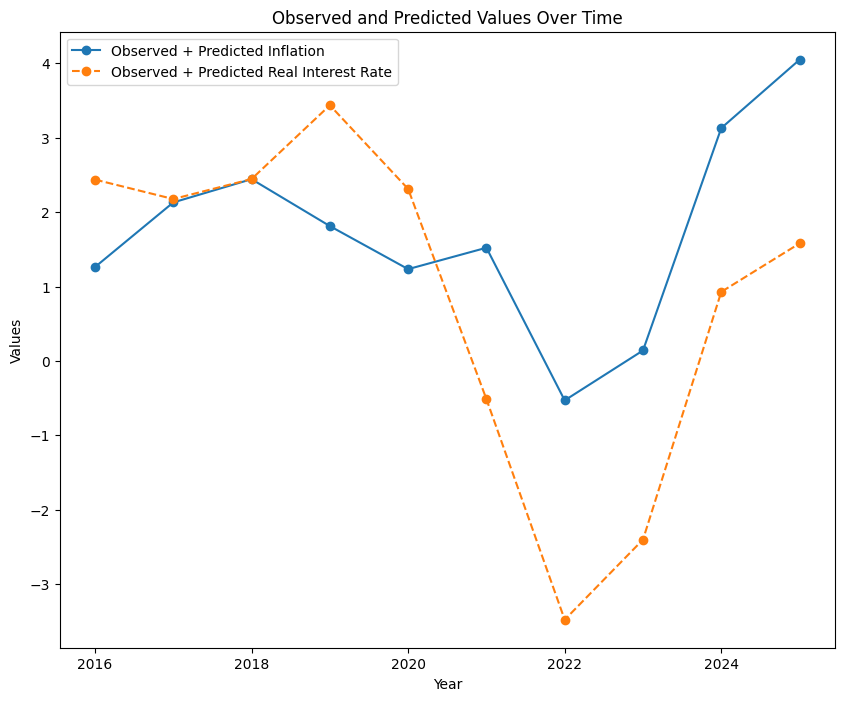

In [461]:
import matplotlib.pyplot as plt

# Assuming mixed_values is your DataFrame with observed and predicted values
plt.plot(mixed_values['year'], mixed_values['Inflation'], label='Observed + Predicted Inflation', marker='o')
plt.plot(mixed_values['year'], mixed_values['Real interest rate (%)'], label='Observed + Predicted Real Interest Rate', linestyle='dashed', marker='o')

plt.xlabel('Year')
plt.ylabel('Values')
plt.title('Observed and Predicted Values Over Time')
plt.legend()
plt.show()

In [462]:
# Assuming df_usa is your original DataFrame
last_observed_inflation = df_usa['Inflation'].tail(5)

# Assuming forecast_df is the DataFrame containing the forecasted values
forecasted_inflation = forecast_df['Inflation'].head(5)

# Combine the last 5 observed values with the forecasted values for the next 5 steps
mixed_inflation = pd.concat([last_observed_inflation, forecasted_inflation])

# Display the mixed inflation values
print("Mixed Inflation Values:")
print(mixed_inflation)

Mixed Inflation Values:
46    1.261583
47    2.130110
48    2.442583
49    1.812210
50    1.233584
0     1.521099
1    -0.530380
2     0.140136
3     3.129182
4     4.047990
Name: Inflation, dtype: float64


Last Observations:
    Real interest rate (%)  year  Inflation
41                1.137338  2011   3.156842
42                1.307083  2012   2.069337
43                1.469299  2013   1.464833
44                1.374742  2014   1.622223
45                2.285696  2015   0.118627
46                2.436851  2016   1.261583
47                2.175694  2017   2.130110
48                2.444494  2018   2.442583
49                3.436010  2019   1.812210
50                2.311111  2020   1.233584

Predicted Inflation for the Next Step:
1.5210985460875763


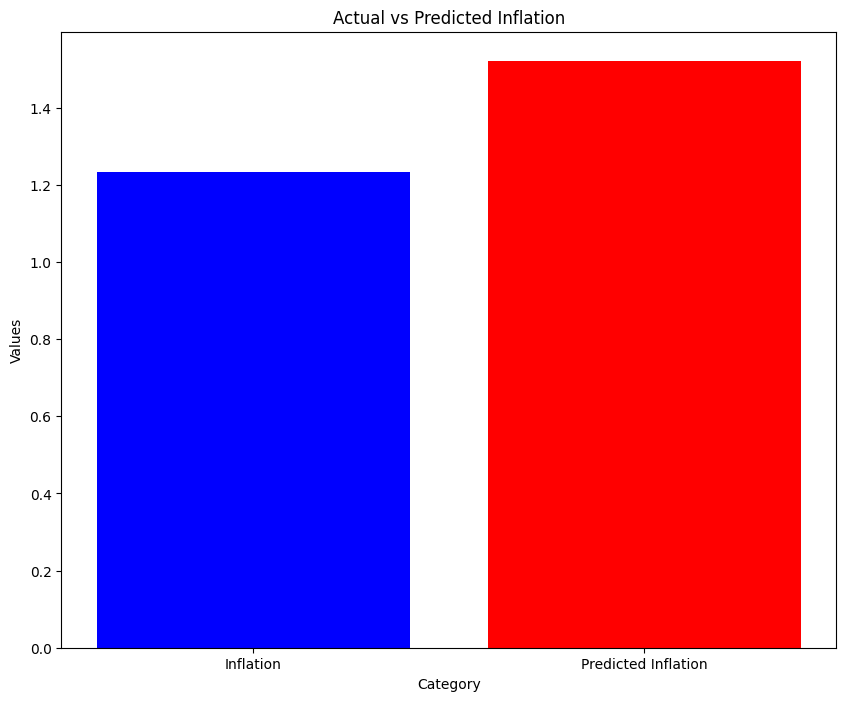

In [463]:
# Assuming df_usa is your DataFrame with columns 'Real interest rate (%)', 'year', and 'Inflation'
# Also assuming you have already trained your VAR model and obtained the forecast

# Extract the lag order from the model
lag_order = results.k_ar

# Extract the last 'lag_order' observations for 'Real interest rate (%)', 'year', and 'Inflation'
last_observations = df_usa[['Real interest rate (%)', 'year', 'Inflation']].iloc[-lag_order:]

# Use the last observations to make a prediction for the next step
prediction_next_step = results.forecast(last_observations.values, steps=1)

# Extract the predicted value for 'Inflation'
predicted_inflation = prediction_next_step[0, -1]

# Display the values
print("Last Observations:")
print(last_observations)
print("\nPredicted Inflation for the Next Step:")
print(predicted_inflation)

# Plot the values
categories = ['Inflation', 'Predicted Inflation']
values = [last_observations['Inflation'].iloc[-1], predicted_inflation]

plt.bar(categories, values, color=['blue', 'red'])
plt.xlabel('Category')
plt.ylabel('Values')
plt.title('Actual vs Predicted Inflation')
plt.show()